In [1]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations
from scipy.spatial.distance import cdist

import os


import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.scipy.special import expit, logsumexp
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
# import pymc_experimental as pmx

import multiprocessing
import socket
from hsgp.approximation import hsgp_squared_exponential


print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.15.1
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.3632e+04, 1.1625e+04, 8.6880e+03, 5.4650e+03, 3.1560e+03,
        1.4630e+03, 5.9200e+02, 1.7700e+02, 4.7000e+01, 5.0000e+00]),
 array([1.68074152e-04, 1.52644491e+00, 3.05272175e+00, 4.57899859e+00,
        6.10527543e+00, 7.63155226e+00, 9.15782910e+00, 1.06841059e+01,
        1.22103828e+01, 1.37366596e+01, 1.52629365e+01]),
 <BarContainer object of 10 artists>)

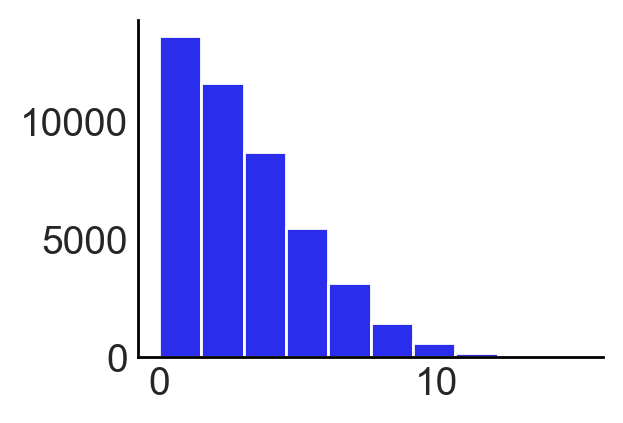

In [4]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
# x2 = rng.binomial(n=1,p=0.25,size=n)

# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = combinations(range(len(x)),2)
x_diff = np.array([abs(x[i] - x[j]) for i, j in idx_pairs])


plt.figure(figsize=(3,2))
plt.hist(x_diff)


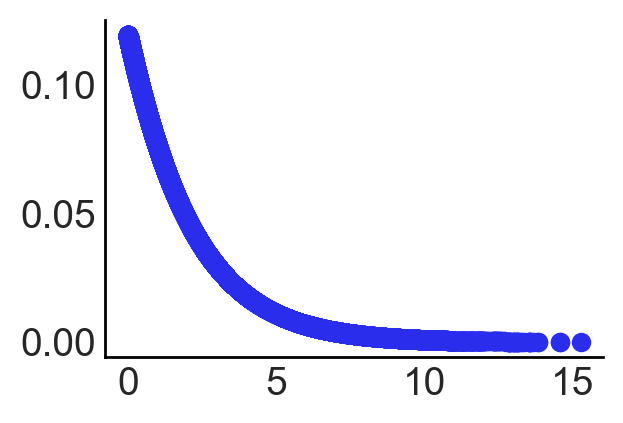

In [5]:
beta = -2, -0.5
# beta = -2, -1
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.figure(figsize=(3,2))
plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [6]:
def eigen_centrality(adj_mat):
    sparse_mat = sp.sparse.csr_matrix(adj_mat)
    _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
    largest_v = eig_vec.flatten().real
    norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
    return largest_v / norm



sum eigen 15.751847377563234


(array([19., 19., 26., 49., 59., 54., 35., 17., 17.,  5.]),
 array([0.00111739, 0.01233845, 0.02355951, 0.03478057, 0.04600163,
        0.05722269, 0.06844375, 0.07966481, 0.09088587, 0.10210693,
        0.11332799]),
 <BarContainer object of 10 artists>)

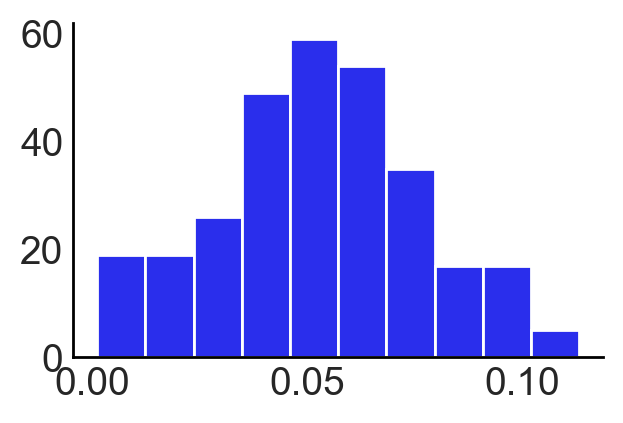

In [7]:
eigen_center = eigen_centrality(mat)
print("sum eigen", np.sum(eigen_center))
plt.figure(figsize=(3,2))
plt.hist(eigen_center)


In [8]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [9]:
# plt.figure(figsize=(5,3))
# np.array(list(eigen_center)).shape
# plt.hist(degrees)
# plt.hist(triangles)
# plt.hist(clustering)
# plt.hist(closeness)
# plt.hist(flow_betweeness)
# plt.hist(betweeness)
# plt.hist(closeness*triangles)
# plt.scatter(deg_center,degrees)
# plt.scatter(degrees,closeness)
# plt.scatter(betweeness,closeness)
# plt.scatter(betweeness,flow_betweeness)
# plt.scatter(triangles,flow_betweeness)
# plt.scatter(app_flow_betweeness,flow_betweeness)
# plt.scatter(triangles,closeness)
# plt.scatter(triangles,betweeness)
# plt.scatter(betweeness,degrees)
# plt.scatter(betweeness,triangles)
# plt.scatter(triangles,degrees)
# plt.scatter(triangles,betweeness)
# plt.scatter(triangles,eigen_center)
# plt.scatter(manual_eig_center,eigen_center)

In [10]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


In [11]:
@jit
def zeigen_value(Z, eig_cen, A_mat):
    if Z.ndim == 1:  # Case when Z has shape (N,)
        return jnp.dot(A_mat, Z * eig_cen)
    elif Z.ndim == 2:  # Case when Z has shape (M, N)
        return jnp.dot(Z * eig_cen, A_mat.T)  # Transpose A_mat for correct dimensions
    # return jnp.dot(Z*eig_cen, A_mat.T)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, jnp.multiply(Z, eig_cen))

           zeigen       expos    exposinv           Z
count  300.000000  300.000000  300.000000  300.000000
mean     0.242005    0.307272   57.056667    0.303333
std      0.156462    0.153598   34.790728    0.460466
min      0.000000    0.000000    0.000000    0.000000
25%      0.122793    0.214286   31.000000    0.000000
50%      0.224863    0.297059   55.500000    0.000000
75%      0.353850    0.391667   81.000000    1.000000
max      0.703032    1.000000  153.000000    1.000000
[[1.        0.5202921]
 [0.5202921 1.       ]]


(array([47., 43., 50., 51., 32., 36., 22.,  7.,  8.,  4.]),
 array([0.        , 0.07030322, 0.14060645, 0.21090968, 0.2812129 ,
        0.35151613, 0.42181936, 0.49212259, 0.56242579, 0.63272905,
        0.70303226]),
 <BarContainer object of 10 artists>)

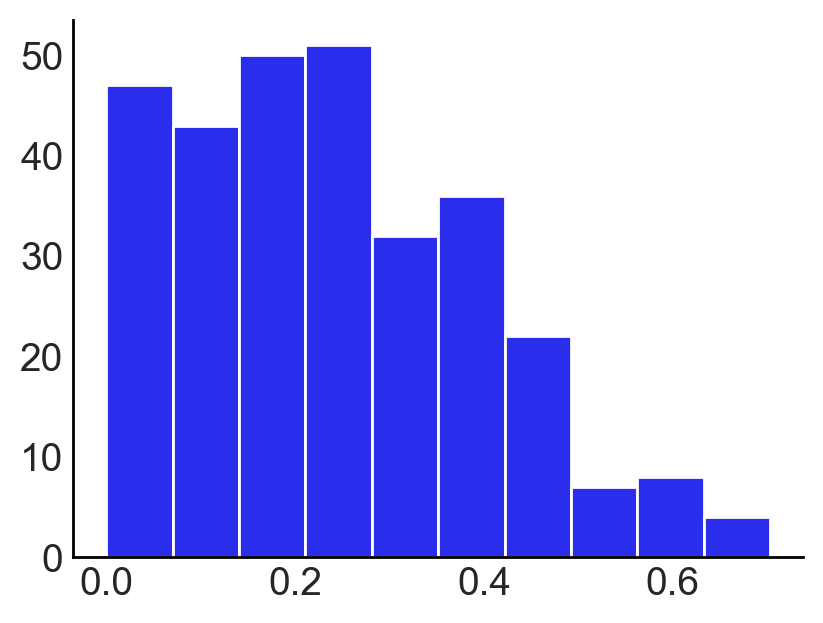

In [12]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
degrees = np.sum(mat,1)
exposures = np.dot(mat,Z) / degrees
exposures_inv_deg = np.dot(mat,Z*degrees)
# print(pd.DataFrame(exposures).describe())
# x_neighbors = np.dot(mat,x) / degrees
# print(pd.DataFrame(x_neighbors).describe())
# print(pd.DataFrame(x).describe())

# Zeigen = np.dot(mat, Z*eigen_center)
Zeigen = zeigen_value(Z, eigen_center, mat)

print(pd.DataFrame({"zeigen": Zeigen,"expos" : exposures, "exposinv":exposures_inv_deg,
                    "Z" : Z}).describe())
print(np.corrcoef(Zeigen,exposures))
# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))

plt.figure(figsize=(4,3))
plt.hist(Zeigen)
# plt.scatter(exposures, Zeigen)
# plt.scatter(exposures_inv_deg, exposures)

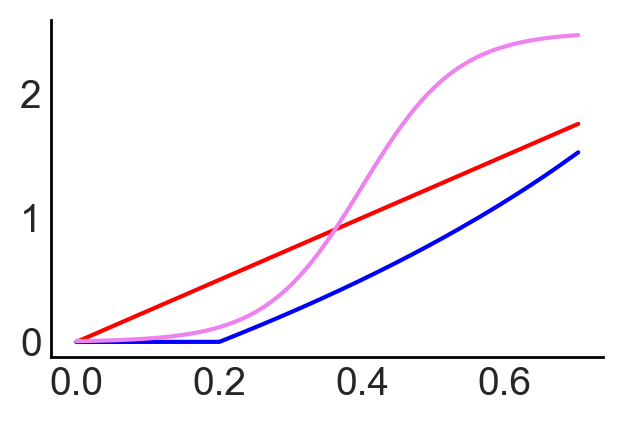

In [13]:
s = np.sort(Zeigen)
f1 = 2.5*s
# f2 = 0*(x < 0.25) + 0.2*np.exp(2*x)*(x>=0.25)
f2 = 0*(s < 0.2) -2.5*(np.log(1-(s-0.2)/1.1))*(s>=0.2)
f3 = 2.5 / (1+np.exp(-15*(s-0.4)))

plt.figure(figsize=(3,2))
plt.plot(s,f1, c="red")
plt.plot(s,f2, c="blue")
plt.plot(s,f3, c="violet")
# plt.axvline(0.25, c="black")


(array([ 3., 12., 24., 61., 80., 40., 22., 32., 23.,  3.]),
 array([-3.62608657, -2.78342613, -1.94076569, -1.09810524, -0.2554448 ,
         0.58721565,  1.42987609,  2.27253653,  3.11519698,  3.95785742,
         4.80051786]),
 <BarContainer object of 10 artists>)

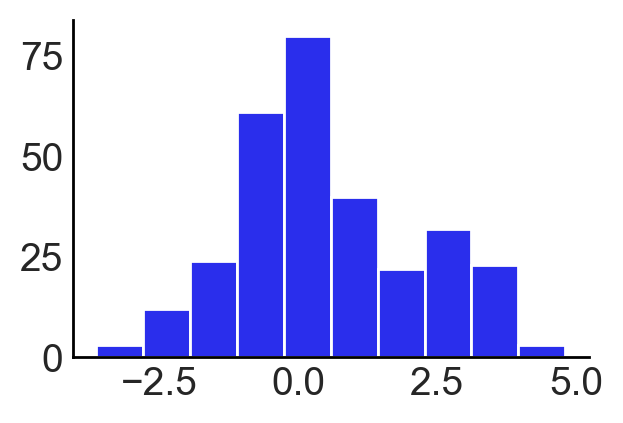

In [14]:
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
# alpha = -1, 3, -.25, 2.5, 2 

alpha = -1, 3, -.25, 2.5 

def gen_y(df_lin, Zeigen, alpha, lin=True):
    Nn = Zeigen.shape[0]
    epsi = rng.normal(loc=0,scale=.5,size=Nn)
    if lin:
        mean_y = np.dot(np.column_stack((df_lin,Zeigen)), alpha)
    else:
        mean_lin = np.dot(df_lin, alpha[0:3]) 
        # mean_nonlin = 0*(Zeigen < 0.2) + (alpha[3]*3)*(Zeigen-0.2)*(Zeigen>=0.2)        
        # mean_nonlin = 0*(Zeigen < 0.2)  - alpha[3]*(np.log(1-(Zeigen-0.2)/1.1))*(Zeigen>=0.2)        
        mean_nonlin = alpha[3] / (1+np.exp(-15*(Zeigen-0.4)))        
        mean_y = mean_lin + mean_nonlin

    Y = mean_y + epsi
    return Y, epsi

# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
# df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen,exposures]))
df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen]))
df_lin = np.transpose(np.array([[1]*n, Z, x]))
# mean_y = np.dot(df_array,alpha)
# # Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
# epsilon = rng.normal(loc=0,scale=1,size=n)
# Y = mean_y + epsilon

Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=False)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)

plt.figure(figsize=(3,2))
plt.hist(Y)


(array([10., 16., 17., 31., 34., 78., 54., 32., 15., 13.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

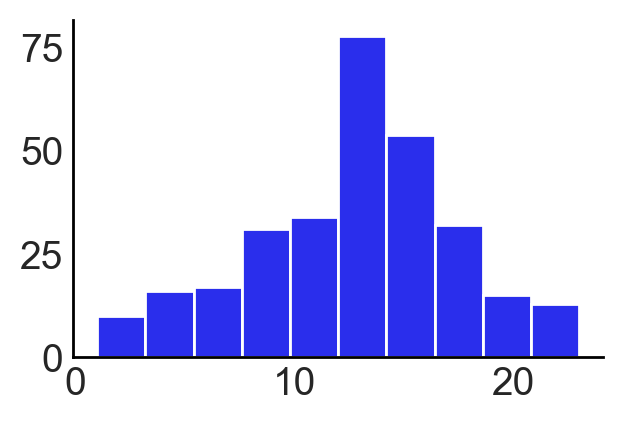

In [15]:
plt.figure(figsize=(3,2))
plt.hist(degrees)

[[1.         0.23672717]
 [0.23672717 1.        ]]


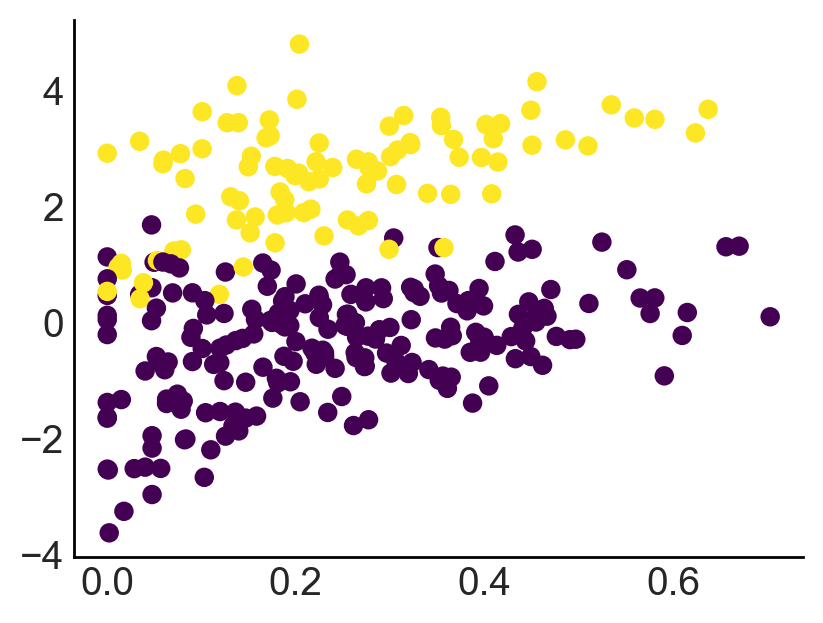

In [16]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

# print(np.corrcoef(eigen_center,Zeigen))
print(np.corrcoef(Zeigen,Y))
# plt.scatter(eigen_center,Zeigen)
plt.scatter(Zeigen,Y,c=Z)
# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

In [17]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [18]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 8., 12., 40., 35., 36., 70., 50., 32., 12.,  5.]),
 array([12. , 14.4, 16.8, 19.2, 21.6, 24. , 26.4, 28.8, 31.2, 33.6, 36. ]),
 <BarContainer object of 10 artists>)

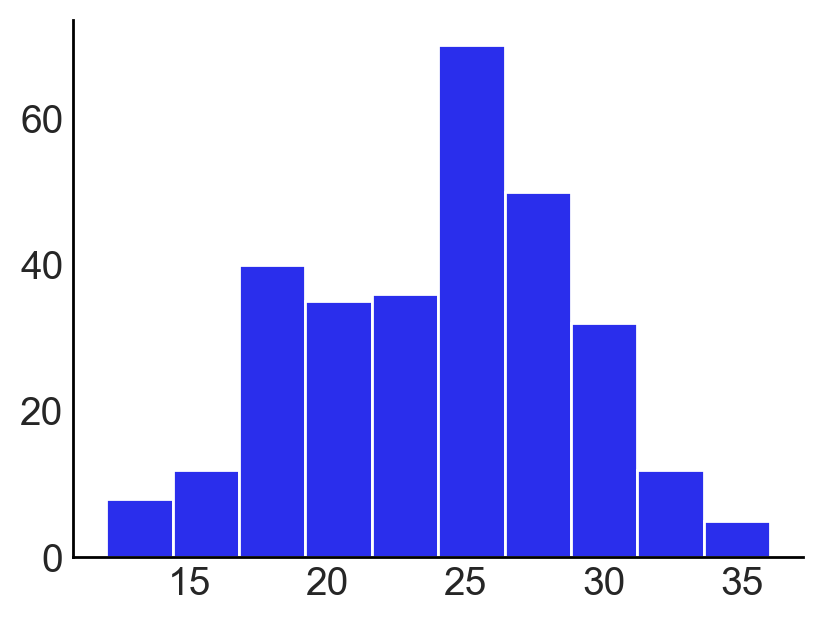

In [19]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
plt.hist(np.sum(obs_mat,1))

In [20]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40784,2157
1.0,467,1442


                0
count  300.000000
mean     0.305400
std      0.098219
min      0.047619
25%      0.238095
50%      0.309019
75%      0.368421
max      0.600000
Corr obs~true exposures:  0.5082920580832014
Corr obs~true Zeigen:  0.6082593038168902


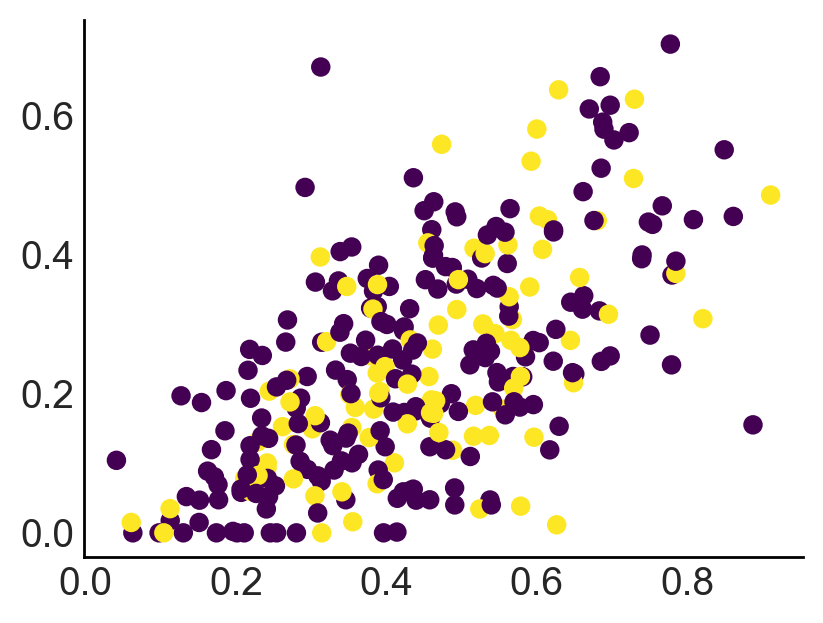

In [21]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_degrees = np.sum(obs_mat,1)
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z) / obs_degrees
# obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)
obs_Zeigen = zeigen_value(Z, obs_eigen_cent, obs_mat)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
# obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen, obs_exposures]))
obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen]))

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
plt.scatter(obs_Zeigen,Zeigen, c=Z)

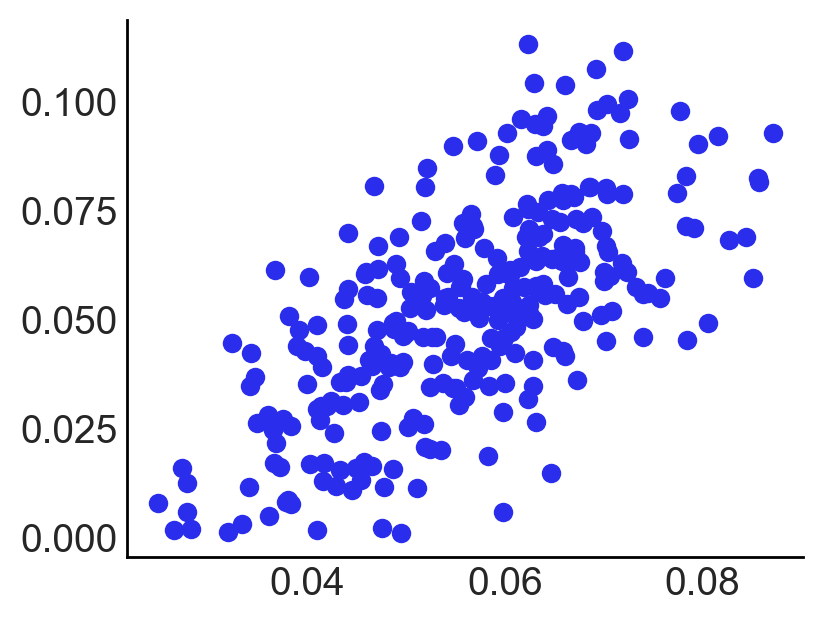

In [22]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_cent, eigen_center)

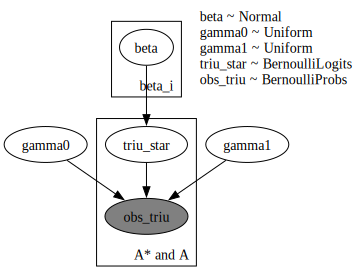

In [23]:
# NumPyro model
# def triu_to_mat(triu, n):
#     adj_mat = jnp.zeros((n,n))
#     idx_utri = np.triu_indices(n=n,k=1)
#     adj_mat = adj_mat.at[idx_utri].set(triu) 
#     return adj_mat + adj_mat.T

NN = n
@jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T


@config_enumerate
def network_model(X, TriU):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    # triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", TriU.shape[0]):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):
# @jit
def outcome_model(X,Y=None):
    with numpyro.plate("Lin coef.",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    sig = numpyro.sample("sig",dist.HalfNormal(scale=2))
    # sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("obs",X.shape[0]):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)
        
        
def HSGP_model(Xlin, Xgp, ell, m, Y=None, non_centered=True):
    # --- Priors ---
    magn = numpyro.sample("magn", dist.HalfNormal(2))
    length = numpyro.sample("length", dist.HalfNormal(5))
    sig = numpyro.sample("sig", dist.HalfNormal(2))
    # --- Parametrization ---
    f = hsgp_squared_exponential(
        x=Xgp, alpha=magn, length=length, ell=ell, m=m, non_centered=non_centered
    )
    with numpyro.plate("Lin coef.",Xlin.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # mu = numpyro.deterministic("mu", jnp.dot(Xlin, alpha) + f)
    mu = jnp.dot(Xlin, alpha) + f
    # mu = beta0 + beta1*x_lin + f
    # --- Likelihood ---
    with numpyro.plate("obs", Xlin.shape[0]):
        # numpyro.sample("likelihood", dist.Normal(loc=mu, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=f, scale=noise), obs=y)
        numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y)
        

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))

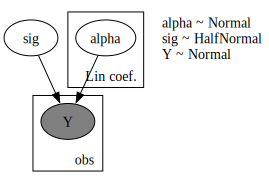

In [24]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)
numpyro.render_model(outcome_model, model_args=(df_array,Y), render_distributions=True)

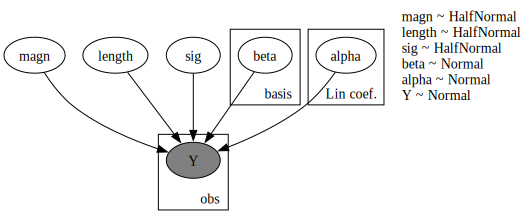

In [25]:
Xgp = df_array[:,3:]
Xlin = df_array[:,0:3]
# ell = 3.5*np.max(np.abs(df_array[:,3:]))
ell = 2*np.max(np.abs(Xgp))
m = 20
# m = 10
# m = 50

numpyro.render_model(HSGP_model, model_args=(Xgp, Xlin, ell, m, Y), render_distributions=True)

In [26]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))  
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -1.90      0.26     -1.91     -2.31     -1.51   4484.94      1.00
   beta[1]     -0.58      0.07     -0.58     -0.69     -0.46   6202.34      1.00
    gamma0      0.05      0.00      0.05      0.05      0.06   6416.06      1.00
    gamma1      0.27      0.15      0.28      0.06      0.50   4580.08      1.00

Number of divergences: 0
385.45824909210205


In [27]:
@jit
def Astar_pred(key, post_samples, Xd, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    return pred_func(key, X=Xd, TriU=triu)
        

In [28]:
# Outcome model with A* (true network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,X=df_array,Y=Y)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
true_net_lin_predictive = Predictive(outcome_model, samples_net_true)

@jit
def outcome_jit_pred(post_samples, df_arr, key=rng_key):
    pred_func = Predictive(outcome_model, post_samples)
    return pred_func(key, df_arr)


# print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.96      0.06     -0.96     -1.06     -0.87   9561.66      1.00
  alpha[1]      2.92      0.07      2.92      2.82      3.03  12826.31      1.00
  alpha[2]     -0.26      0.01     -0.26     -0.27     -0.24  14442.00      1.00
  alpha[3]      2.47      0.19      2.47      2.17      2.79  10094.89      1.00
       sig      0.51      0.02      0.51      0.48      0.55  14133.39      1.00

Number of divergences: 0


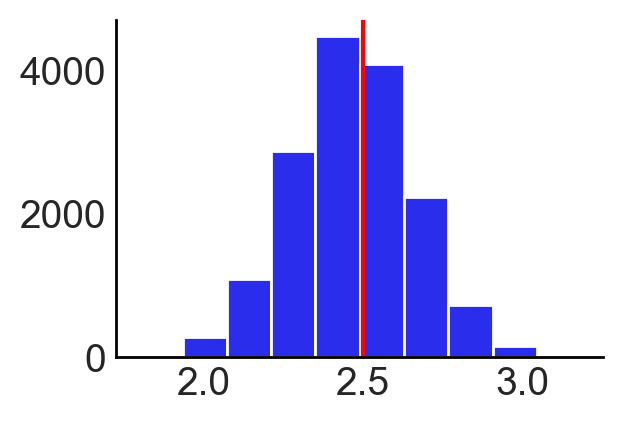

In [29]:
plt.figure(figsize=(3,2))
plt.hist(samples_net_true["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [30]:
# Outcome model with A (observed network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_, X=obs_df, Y=Y)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
obs_net_lin_predictive = Predictive(outcome_model, samples_net_obs)

# print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.96      0.10     -0.96     -1.12     -0.81   8984.11      1.00
  alpha[1]      2.88      0.08      2.88      2.76      3.01  15344.00      1.00
  alpha[2]     -0.25      0.01     -0.25     -0.27     -0.23  15564.41      1.00
  alpha[3]      1.38      0.20      1.38      1.06      1.71   9144.33      1.00
       sig      0.60      0.02      0.60      0.56      0.64  16189.34      1.00

Number of divergences: 0


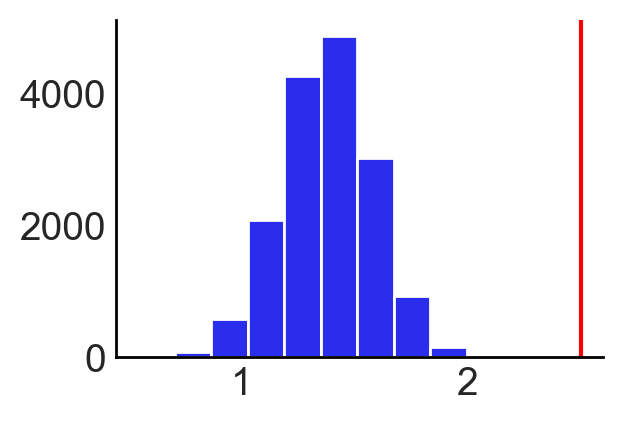

In [31]:
plt.figure(figsize=(3,2))
plt.hist(samples_net_obs["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [32]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -2', 'beta_1 = -0.5'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = -0.25', 'alpha_3 = 2.5'] sig: 1


In [33]:
# start = time.time()
kernel_gp_outcome = NUTS(HSGP_model)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,Xgp=Xgp, Xlin=Xlin, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_true.print_summary()
samples_GP_net_true = mcmc_GP_network_true.get_samples()
# print(time.time() - start)
HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)




  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.28      0.94     -0.27     -1.87      1.25   1337.14      1.00
  alpha[1]      2.92      0.07      2.92      2.81      3.03   2205.98      1.00
  alpha[2]     -0.26      0.01     -0.26     -0.28     -0.24   2614.78      1.00
   beta[0]     -0.23      0.96     -0.23     -1.73      1.41   1523.75      1.00
   beta[1]     -0.95      0.74     -0.94     -2.12      0.28   1846.52      1.00
   beta[2]      0.82      0.69      0.79     -0.33      1.95   1602.35      1.00
   beta[3]      0.17      0.72      0.18     -0.94      1.39   1479.09      1.00
   beta[4]     -0.19      0.89     -0.19     -1.66      1.24   1900.59      1.00
   beta[5]     -0.12      0.93     -0.10     -1.67      1.38   1987.42      1.00
   beta[6]      0.01      0.96     -0.01     -1.47      1.69   2152.34      1.00
   beta[7]      0.10      0.99      0.11     -1.55      1.65   2280.80      1.00
   beta[8]     -0.02      1

In [35]:
# HSGP with noisy data
Xlin_obs = obs_df[:,0:3]
Xgp_obs = obs_df[:,3:]
ell_obs = 2*np.max(np.abs(Xgp_obs))


kernel_gp_outcome = NUTS(HSGP_model)
mcmc_GP_network_obs = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_GP_network_obs.run(rng_key_,Xgp=Xgp_obs, Xlin=Xlin_obs, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_obs.print_summary()
mcmc_GP_network_obs = mcmc_GP_network_obs.get_samples()
# print(time.time() - start)
HSGP_obs_predictive = Predictive(HSGP_model, mcmc_GP_network_obs)



  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.54      0.75     -0.49     -1.80      0.63    638.65      1.01
  alpha[1]      2.88      0.08      2.88      2.75      3.01   1686.69      1.00
  alpha[2]     -0.25      0.01     -0.25     -0.27     -0.23   1365.16      1.00
   beta[0]     -0.11      0.92     -0.12     -1.56      1.48    807.82      1.01
   beta[1]     -0.56      0.80     -0.53     -1.90      0.72   1370.66      1.00
   beta[2]      0.74      0.71      0.71     -0.41      1.93   1031.73      1.01
   beta[3]     -0.10      0.75     -0.09     -1.33      1.14   1118.57      1.00
   beta[4]     -0.25      0.86     -0.25     -1.61      1.15    861.12      1.00
   beta[5]      0.11      0.94      0.11     -1.46      1.64   1420.36      1.00
   beta[6]     -0.03      0.98     -0.03     -1.58      1.62    832.03      1.00
   beta[7]      0.07      0.98      0.07     -1.51      1.70   1647.73      1.00
   beta[8]      0.01      0

In [36]:
@jit
def HSGP_jit_pred(post_samples, Xgp, Xlin, ell, m):
    pred_func = Predictive(HSGP_model, post_samples)
    return pred_func(rng_key, Xgp=Xgp, Xlin = Xlin, ell=ell, m=m)


@jax.vmap
def vectorized_predict(Xgp_batch, Xlin_batch, ell_batch, m_batch):
    return HSGP_true_predictive(rng_key, Xgp=Xgp_batch, Xlin=Xlin_batch, ell=ell_batch, m=m_batch)


In [37]:
# h_x = ((x > 1.5) | (x < -1.5)).astype(int)
# h_x2 = ((x > 2) | (x < 2)).astype(int)

def Dynamic_intervention(x, threshold = 1.5):
    return np.where((x > threshold) | (x < -threshold), 1, 0)
    # return ((x > threshold) | (x < threshold)).astype(int)

def Stochastic_interention(alph, n_approx = 1e4):
    return rng.binomial(n=1, p=alph, size=(n_approx,n))
# 
# # h_x = np.array([1]*n)
# h_x = rng.binomial(n=1,p=0.6,size=n)
# h_x2 = rng.binomial(n=1,p=0.2,size=n)

h_1 = Dynamic_intervention(x)
Z_stoch = Stochastic_interention(alph=0.4, n_approx=10)

h_zeigen = zeigen_value(h_1, eigen_center, mat)
h_zeigen_obs = zeigen_value(h_1, obs_eigen_cent, obs_mat)

Stoch_zeigen = zeigen_value(Z_stoch, eigen_center, mat)

print(h_1.shape)
print(h_zeigen.shape)
print(Z_stoch.shape)
print(Stoch_zeigen.shape)

(300,)
(300,)
(10, 300)
(10, 300)


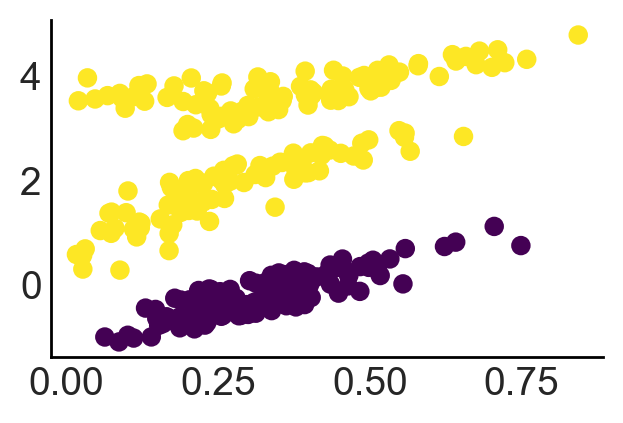

In [83]:
X_h_true = np.transpose(np.array([[1]*n, h_1, x, h_zeigen]))
X_h_obs = np.transpose(np.array([[1]*n, h_1, x, h_zeigen_obs]))

# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=True)
# Y_test2,_ = gen_y(X_test_true2[:,0:3], true_h_x_eigen2,alpha,lin=False)

mu_test = Y_test - epsi_test
true_estimand = np.mean(mu_test)
# true_ce = Y_test - Y_test2

plt.figure(figsize=(3,2))
plt.scatter(h_zeigen,mu_test, c=h_1)
# plt.scatter(mean_y,mu_test, c =h_x)

In [100]:
def compute_error_stats(esti_post_draws, true_estimand, method="TEST", iter=None):
    mean = np.round(np.mean(esti_post_draws),3) 
    medi = np.round(np.median(esti_post_draws),3) 
    std = np.round(np.std(esti_post_draws),3)
    RMSE = np.round(np.sqrt(np.mean(np.power(esti_post_draws - true_estimand, 2))),3)
    q025 = np.round(np.quantile(esti_post_draws, 0.025),3)
    q975 = np.round(np.quantile(esti_post_draws, 0.975),3)
    cover = q025 <= true_estimand <= q975
    return {"iter" : iter, "method" : method,
            "mean" : mean, "median" : medi, "true" : np.round(true_estimand,3), 
            "bias" : mean - true_estimand, "std" : std, "RMSE" : RMSE,
            "q025" : q025, "q975" : q975, "covering" : cover}

(16000, 300)
(16000,)
{'iter': None, 'method': 'TEST', 'mean': Array(1.562, dtype=float32), 'median': 1.562, 'true': 1.582, 'bias': Array(-0.01978624, dtype=float32), 'std': Array(0.048, dtype=float32), 'RMSE': 0.052, 'q025': 1.468, 'q975': 1.658, 'covering': True}


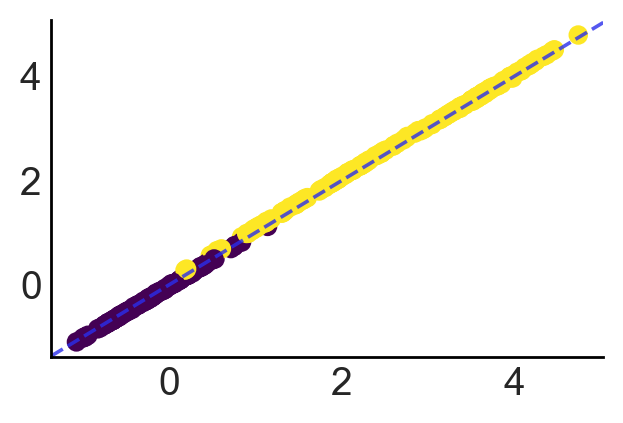

In [101]:
# post_pred_true_net = true_net_lin_predictive(rng_key, X=X_h_true)
post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
print(post_pred_true_net["Y"].shape)
# post_pred_true_net2 = true_net_lin_predictive(rng_key, X=X_test_true2)
lin_pred_true_net = np.mean(post_pred_true_net["Y"],axis=0)
lin_pred_true_net_it = np.mean(post_pred_true_net["Y"],axis=1)
print(lin_pred_true_net_it.shape)

lin_pred_true_stats = compute_error_stats(np.mean(post_pred_true_net["Y"],axis=1), true_estimand)
print(lin_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_true_net,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

{'mean': Array(1.7990001, dtype=float32), 'median': 1.799, 'true': 1.582, 'bias': Array(0.21721387, dtype=float32), 'std': Array(0.082, dtype=float32), 'RMSE': 0.232, 'q025': 1.638, 'q975': 1.958, 'covering': False}


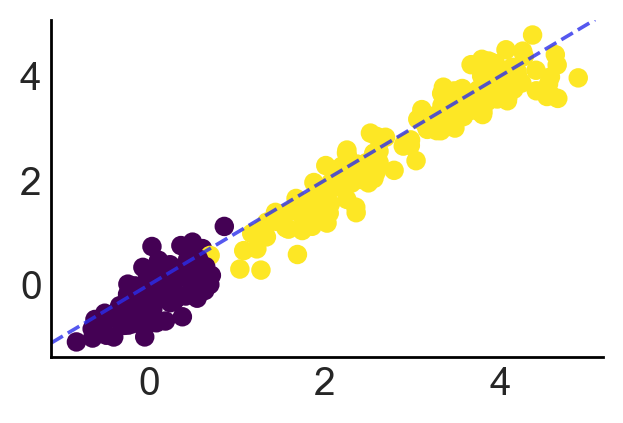

In [88]:
post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
lin_pred_obs = np.mean(post_pred_obs["Y"],axis=0)
lin_pred_obs_it = np.mean(post_pred_obs["Y"],axis=1)

lin_pred_obs_stats = compute_error_stats(np.mean(post_pred_obs["Y"],axis=1), true_estimand)
print(lin_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_obs,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(16000, 300)
{'mean': Array(1.5560001, dtype=float32), 'median': 1.556, 'true': 1.582, 'bias': Array(-0.02578616, dtype=float32), 'std': Array(0.048, dtype=float32), 'RMSE': 0.055, 'q025': 1.461, 'q975': 1.652, 'covering': True}


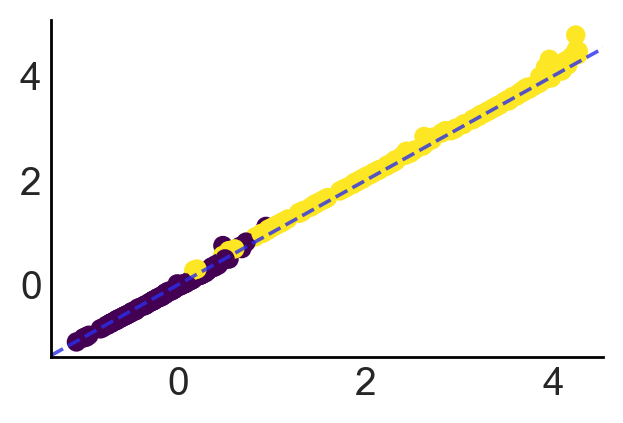

In [89]:
HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive["Y"].shape)
post_mu = np.mean(HSGP_posterior_predictive["Y"],axis=0)
post_mu_iter = np.mean(HSGP_posterior_predictive["Y"],axis=1)

hsgp_pred_true_stats = compute_error_stats(np.mean(HSGP_posterior_predictive["Y"],axis=1), true_estimand)
print(hsgp_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(16000, 300)
{'mean': Array(1.5610001, dtype=float32), 'median': 1.561, 'true': 1.582, 'bias': Array(-0.02078617, dtype=float32), 'std': Array(0.11400001, dtype=float32), 'RMSE': 0.116, 'q025': 1.327, 'q975': 1.79, 'covering': True}


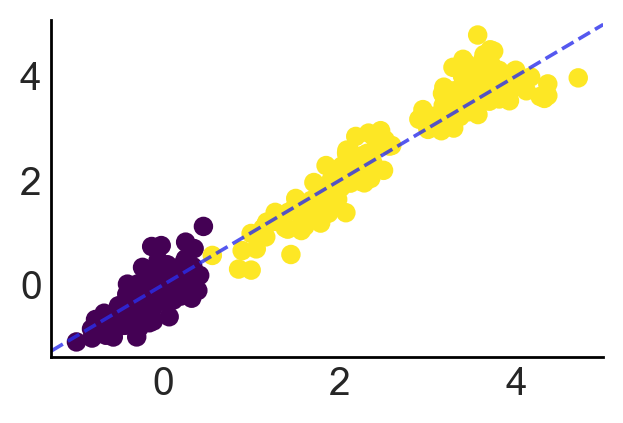

In [91]:
HSGP_posterior_predictive_obs = HSGP_obs_predictive(rng_key, Xgp=X_h_obs[:,3:], Xlin = X_h_obs[:,0:3],ell=ell_obs, m=m)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive_obs["Y"].shape)
obs_post_mu = np.mean(HSGP_posterior_predictive_obs["Y"],axis=0)
obs_post_mu_iter = np.mean(HSGP_posterior_predictive_obs["Y"],axis=1)

hsgp_pred_obs_stats = compute_error_stats(np.mean(HSGP_posterior_predictive_obs["Y"],axis=1), true_estimand)
print(hsgp_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=obs_post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)


In [93]:
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)

{'beta': Array([[-1.9016219, -0.580249 ]], dtype=float32), 'gamma0': Array([0.05234896], dtype=float32), 'gamma1': Array([0.27144083], dtype=float32)}


In [94]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
# print(jnp.array(post_pred_mean))
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
# a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=samples_network, Xd=x_diff,triu=triu_obs)
a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
a_star_pred2 = Astar_pred(random.PRNGKey(3),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
# a_star_pred2 = Astar_pred(random.PRNGKey(),post_samples=jnp.array(post_pred_mean), Xd=x_diff,triu=triu_obs, mean_post=True)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred1["triu_star"][0].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
(1, 44850)
(44850,)
(1, 44850)
False


sec,0,1
first,,
0,41747,1224
1,1203,676


In [95]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs)
# samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [99]:

st = time.time()
for i in range(100):
    # A2 = Triu_to_mat(a_star_pred1["triu_star"][i])
     Triu_to_mat(Astar_pred(random.PRNGKey(i),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)["triu_star"][0])
    #  Triu_to_mat(post_predictive["triu_star"][i,])
print("jax.jit takes: ", time.time() - st)

# np.array(Triu_to_mat(a_star_pred1["triu_star"][0])).shape

# print(np.array_equal(A1,A2))


jax.jit takes:  3.032487392425537


In [ ]:
NN = n

@jit
def linear_model_samples(key, Y, df, n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit
def HSGP_model_samples(key, Y, Xgp, Xlin, ell, m , n_warmup=500, n_samples=250, n_chains=2):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=m, Y=Y)
    samples = hsgp_mcmc.get_samples()
    hsgp_pred = Predictive(HSGP_model, samples)
    return samples, hsgp_pred

def twostage_jj(Astar_pred, Y, Z, X, x_diff, triu_obs, i, m, true_estimand):
    cur_key = random.PRNGKey(i)
    # sample network
    curr_triu_star = Astar_pred(cur_key,post_samples=samples_network, Xd=x_diff,triu=triu_obs)
    curr_Astar = Triu_to_mat(curr_triu_star["triu_star"][0])
    if Z.ndim == 1:
        # net stats
        cur_eigen_cen = eigen_centrality(curr_Astar)
        cur_Zeigen = zeigen_value(Z, cur_eigen_cen, curr_Astar)
        cur_ell = 2*np.max(np.abs(cur_Zeigen))
        # get df
        cur_df = np.transpose(np.array([[1]*NN,Z,X,cur_Zeigen]))
        # Run MCMC
        cur_lin_samples = linear_model_samples(cur_key, Y, cur_df)
        cur_hsgp_samples, cur_hsgp_predictive = HSGP_model_samples(cur_key, Y=Y, Xgp=cur_df[:,3:],
                                                                    Xlin=cur_df[:,0:3], ell=cur_ell, m=m)
        # get predictive values (shape is (n_samples*n_chains, n))
        # TODO: need to to save each (n_samples*n_chains, n) results in a (L, n_samples*n_chains, n) array
        # TODO: each row (first dim) is (n_samples*n_chains, n) results from one iteration
        # TODO: save one for linear and one for HSGP model
        # TODO: think how to combine those values in the `compute_error_stats()' function after the loop below
        cur_lin_pred = outcome_jit_pred(cur_lin_samples, cur_df, cur_key)
        cur_hsgp_pred = cur_hsgp_predictive(cur_key, Xgp=cur_df[:,3:], Xlin=cur_df[:,0:3],
                                            ell=cur_ell, m=m)
        
    if Z.ndim == 2:
        # TODO: add option here for stochastic estimands
        return 
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
start = time.time()
twostage_post_samp_jit = pd.DataFrame()
# for i in tqdm(range(50)):
for i in tqdm(range(500)):
    cur_res = twostage_jj(Astar_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

In [ ]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))

plt.figure(figsize=(4,3))
plt.hist(twostage_post_samp_jit["alpha_3"])
plt.axvline(x=alpha[3], color="red")
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

In [ ]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models

# TODO: update here similar to the `twostage' solution

def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    # curr_Astar = triu_to_mat(triu_post_samp, NN)
    curr_Astar = Triu_to_mat(triu_post_samp)
    # compute stats
      # expos = np.dot(curr_Astar,Z)
    cur_eigen_cen = eigen_centrality(curr_Astar)
    cur_Zeigen = jnp.dot(curr_Astar,Z*cur_eigen_cen)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    # expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    # cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    cur_df = np.transpose(np.array([[1]*NN,Z,X,cur_Zeigen]))
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
#      
# kernel_outcome = NUTS(outcome_model)
# # mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=1000, num_samples=100,num_chains=2, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


K = 500
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)




In [ ]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.figure(figsize=(4,3))
plt.hist(threestage_post_samp_jit["alpha_3"])
plt.axvline(x=alpha[3], color="red")

In [ ]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


In [ ]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



In [ ]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).

# TODO: update here. should be relatively easy since we have only one outcome MCMC here. 

def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    eig_cen_list = []
    Zeigen_list = []
    
    for i in i_range:
        # sample network
        # curr_Astar = triu_to_mat(net_post_samples[i,], n)
        curr_Astar = Triu_to_mat(net_post_samples[i,])
        # compute stat
        # expos, eig_cen, between = compute_net_stats(curr_Astar, Z)
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([jnp.sum(curr_Astar,1)])
        expos_list.append([jnp.dot(curr_Astar, Z)])
        
        cur_eig_cen = eigen_centrality(curr_Astar)
        eig_cen_list.append([cur_eig_cen])
        Zeigen_list.append([jnp.dot(curr_Astar, Z*cur_eig_cen)])
        
               
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
        if i == max(i_range)//2:
            print("mid way")
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list,
            'eig_cen' : eig_cen_list,
            'Zeigen' : Zeigen_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


In [ ]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
mean_eig_cen = np.mean(onestage_net_stat["eig_cen"],axis=0)
mean_Zeigen = np.mean(onestage_net_stat["Zeigen"],axis=0)

# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,degrees)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("zeigen corr", np.corrcoef(mean_Zeigen,Zeigen)[1,0])
# print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
# print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (4,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.scatter(mean_expos,exposures, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_Zeigen, Zeigen,)
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("mean pred Zeigen")
ax1.set_ylabel("True expos")
ax2.set_ylabel("True Zeigen")


In [ ]:
np.transpose(np.array(mean_Zeigen))[:,:].shape

In [ ]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
# ax1.scatter(mean_Zeigen, Zeigen, marker = 'o')
ax1.scatter(mean_eig_cen, eigen_center, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.scatter(obs_eigen_cent, eigen_center,marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred zeigen")
ax2.set_xlabel("observed zeigen")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [ ]:

mean_Zeigen = np.reshape(mean_Zeigen, (300,))
one_stage_df = np.transpose(np.array([[1]*n, Z, x, mean_Zeigen]))

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,X=one_stage_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

In [ ]:
plt.figure(figsize=(4,3))
plt.hist(samples_network_stat["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [ ]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [ ]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [ ]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


In [ ]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [ ]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [ ]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


In [ ]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [ ]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [ ]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)